In [19]:
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv
from cerebras.cloud.sdk import Cerebras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import json

In [20]:
load_dotenv()

client = Cerebras(api_key=os.getenv('CEREBRAS_API_KEY'))

Path('results').mkdir(exist_ok=True)
Path('figures').mkdir(exist_ok=True)

print("Setup complete")

Setup complete


## 1. Load Dataset

In [21]:
df = pd.read_csv('data/yelp_sample_200.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nRating distribution:")
print(df['stars'].value_counts().sort_index())

df.head()

Dataset shape: (200, 10)

Rating distribution:
stars
1    18
2    17
3    33
4    79
5    53
Name: count, dtype: int64


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,QVR7dsvBeg8xFt9B-vd1BA,2010-07-22,hwYVJs8Ko4PMjI19QcR57g,4,We got here around midnight last Friday... the...,review,90a6z--_CUrl84aCzZyPsg,5,5,2
1,24qSrF_XOrvaHDBy-gLIQg,2012-01-22,0mvthYPKb2ZmKhCADiKSmQ,5,Brought a friend from Louisiana here. She say...,review,9lJAj_2zCvP2jcEiRjF9oA,0,0,0
2,j0Uc-GuOe-x9_N_IK1KPpA,2009-05-09,XJHknNIecha6h0wkBSZB4w,3,"Every friday, my dad and I eat here. We order ...",review,0VfJi9Au0rVFVnPKcJpt3Q,0,0,0
3,RBiiGw8c7j-0a8nk35JO3w,2010-12-22,z6y3GRpYDqTznVe-0dn--Q,1,"My husband and I were really, really disappoin...",review,lwppVF0Yqkuwt-xaEuugqw,2,2,2
4,U8VA-RW6LYOhxR-Ygi6eDw,2011-01-17,vhWHdemMvsqVNv5zi2OMiA,5,Love this place! Was in phoenix 3 weeks for w...,review,Y2R_tlSk4lTHiLXTDsn1rg,0,1,0


## 2. Load Prompt Templates

In [22]:
with open('prompts/zero_shot.txt', 'r') as f:
    zero_shot_template = f.read()

with open('prompts/few_shot.txt', 'r') as f:
    few_shot_template = f.read()

with open('prompts/chain_of_thought.txt', 'r') as f:
    cot_template = f.read()

print("Prompt templates loaded")
print(f"\nPrint Zero-shot template:\n\n{zero_shot_template}")

Prompt templates loaded

Print Zero-shot template:

You are predicting the Yelp review star rating as an integer from 1 to 5.

Use this rubric:
- 1: very negative (strong complaints, would not return)
- 2: negative (more bad than good)
- 3: mixed/neutral (okay, average, pros and cons)
- 4: positive (mostly good, minor issues)
- 5: very positive (strong praise, highly satisfied)

Rules:
- Output MUST be a single JSON object and nothing else.
- "predicted_stars" MUST be an integer 1-5 (no words, no decimals).
- "explanation" should be 1-2 short sentences citing key evidence.

Return ONLY valid JSON in exactly this schema:
{{
	"predicted_stars": <integer 1-5>,
	"explanation": "<brief evidence-based explanation>"
}}

Review: {review_text}


## 3. Prompt Generation Functions

In [23]:
def zero_shot_prompt(review_text):
    return zero_shot_template.format(review_text=review_text)

def few_shot_prompt(review_text, examples):
    # Format examples in a way that matches the required JSON output shape
    examples_text = "\n\n".join(
        [
            (
                f"Review: {ex['text']}\n"
                f"Output: {{\"predicted_stars\": {ex['rating']}, \"explanation\": \"...\"}}"
            )
            for ex in examples
        ]
    )
    return few_shot_template.format(
        examples=examples_text,
        review_text=review_text
    )

def chain_of_thought_prompt(review_text):
    return cot_template.format(review_text=review_text)

print("Prompt functions ready")

Prompt functions ready


## 4. Select Few-shot Examples

In [24]:
# Few-shot selection with all 5 ratings, 2 examples each

def select_clear_examples(df, rating, n=2, max_len=120):
    """
    Pick examples with clear sentiment indicators for the given rating.
    Prefer shorter reviews that are unambiguous.
    """
    subset = df[df['stars'] == rating].copy()
    if len(subset) == 0:
        return []
    
    # Score reviews: prefer shorter ones with strong sentiment words
    positive_words = ['amazing', 'excellent', 'love', 'best', 'fantastic', 'great', 'perfect', 'delicious']
    negative_words = ['terrible', 'awful', 'worst', 'horrible', 'bad', 'disgusting', 'never', 'waste']
    neutral_words = ['okay', 'average', 'decent', 'fine', 'nothing special']
    
    def clarity_score(text):
        text_lower = text.lower()
        length_score = max(0, 300 - len(text)) / 300  # Prefer shorter
        
        if rating >= 4:
            sentiment_score = sum(1 for w in positive_words if w in text_lower)
        elif rating <= 2:
            sentiment_score = sum(1 for w in negative_words if w in text_lower)
        else:
            sentiment_score = sum(1 for w in neutral_words if w in text_lower)
        
        return length_score + sentiment_score * 0.5
    
    subset['clarity'] = subset['text'].apply(clarity_score)
    subset = subset.sort_values('clarity', ascending=False)
    
    selected = []
    for _, row in subset.head(n).iterrows():
        # Truncate to max_len, try to end at sentence boundary
        text = row['text'][:max_len]
        if len(row['text']) > max_len:
            last_period = text.rfind('.')
            if last_period > max_len // 2:
                text = text[:last_period + 1]
        selected.append({'text': text, 'rating': rating})
    
    return selected


# Build few-shot examples: 2 per rating class (10 total)
few_shot_examples = []
for rating in [1, 2, 3, 4, 5]:
    examples = select_clear_examples(df, rating, n=2, max_len=120)
    few_shot_examples.extend(examples)

print(f"Few-shot examples ({len(few_shot_examples)} examples across all 5 ratings):\n")
for ex in few_shot_examples:
    print(f"{ex['rating']}: {ex['text'][:80]}...")
    print()

Few-shot examples (10 examples across all 5 ratings):

1: When owners/staff changed we kept hoping for the best.  (The friendly owners/coo...

1: Disgusting!  Had a Groupon so my daughter and I tried it out.  Very outdated and...

2: Well I just wasted 38 bucks....never again...

2: Wasn't impressed. Dressing tasted like a store bought bottle dressing and tomato...

3: I don't know what Bar Smith is trying to be. I feel like instead of just saying ...

3: The very definition of an average brunch.  My omelet was pretty decent, and it's...

4: Someone asked the question in the Yelp talk threads where the best place was for...

4: I had my first meal at Miele's last night, and was pleasantly surprised....

5: Love this place! Wish we had one here in CA. Great vibe once you walk through th...

5: When I moved to the Valley, our first place was a rental in Old Town....



## 5. LLM Prediction Function

In [25]:
def _extract_json_object(text: str):
    """Best-effort: extract the first JSON object from text."""
    start = text.find('{')
    end = text.rfind('}')
    if start == -1 or end == -1 or end <= start:
        raise ValueError("No JSON object found")
    return text[start : end + 1]


def _parse_llm_json(response_text: str):
    """Parse {"predicted_stars": int, "explanation": str} with safeguards."""
    raw = _extract_json_object(response_text)
    data = json.loads(raw)

    if "predicted_stars" not in data:
        raise ValueError("Missing predicted_stars")

    predicted = int(data["predicted_stars"])
    if predicted < 1 or predicted > 5:
        raise ValueError("predicted_stars out of range")

    explanation = data.get("explanation", "")
    if explanation is None:
        explanation = ""
    explanation = str(explanation).strip()

    return predicted, explanation


def get_rating_prediction(prompt, model="llama3.1-8b", system_prompt=None):
    """Call Cerebras API, return (predicted_stars, explanation, raw_response)."""
    try:
        messages = []
        if system_prompt:
            messages.append({"role": "system", "content": system_prompt})
        messages.append({"role": "user", "content": prompt})

        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0.0,
            max_tokens=120,
        )

        response_text = response.choices[0].message.content.strip()

        try:
            predicted, explanation = _parse_llm_json(response_text)
            return predicted, explanation, response_text
        except Exception:
            # Fallback: keep old behavior if model deviates
            match = re.search(r"[1-5]", response_text)
            predicted = int(match.group()) if match else None
            return predicted, "", response_text

    except Exception as e:
        return None, "", str(e)


print("Prediction function ready")

Prediction function ready


## 6. Run Predictions

In [ ]:
test_df = df.copy()  

# Store parsed outputs + raw responses
results_data = {
    'zero_shot': {'predicted_stars': [], 'explanations': [], 'responses': []},
    'few_shot': {'predicted_stars': [], 'explanations': [], 'responses': []},
    'chain_of_thought': {'predicted_stars': [], 'explanations': [], 'responses': []}
}

cot_system_prompt = (
    "You are a strict rater. Think step-by-step internally, but do not reveal reasoning. "
    "Return ONLY the required JSON object."
 )

print(f"Running predictions on {len(test_df)} reviews...\n")

for idx, row in test_df.iterrows():
    review_text = row['text']

    # Zero-shot
    prompt = zero_shot_prompt(review_text)
    pred, expl, resp = get_rating_prediction(prompt)
    results_data['zero_shot']['predicted_stars'].append(pred)
    results_data['zero_shot']['explanations'].append(expl)
    results_data['zero_shot']['responses'].append(resp)

    # Few-shot
    prompt = few_shot_prompt(review_text, few_shot_examples)
    pred, expl, resp = get_rating_prediction(prompt)
    results_data['few_shot']['predicted_stars'].append(pred)
    results_data['few_shot']['explanations'].append(expl)
    results_data['few_shot']['responses'].append(resp)

    # Chain-of-Thought
    prompt = chain_of_thought_prompt(review_text)
    pred, expl, resp = get_rating_prediction(prompt, system_prompt=cot_system_prompt)
    results_data['chain_of_thought']['predicted_stars'].append(pred)
    results_data['chain_of_thought']['explanations'].append(expl)
    results_data['chain_of_thought']['responses'].append(resp)

    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{len(test_df)} reviews")

    time.sleep(0.1)  # Rate limiting

print("\nPredictions complete")

Running predictions on 200 reviews...

Processed 10/200 reviews
Processed 20/200 reviews
Processed 30/200 reviews
Processed 40/200 reviews
Processed 50/200 reviews
Processed 60/200 reviews
Processed 70/200 reviews
Processed 80/200 reviews
Processed 90/200 reviews
Processed 100/200 reviews
Processed 110/200 reviews
Processed 120/200 reviews
Processed 130/200 reviews


## 7. Save Predictions

In [ ]:
for strategy, data in results_data.items():
    result_df = test_df.copy()
    result_df['predicted_stars'] = data['predicted_stars']
    result_df['explanation'] = data['explanations']
    result_df['llm_response'] = data['responses']

    output_file = f'results/{strategy}_predictions.csv'
    result_df.to_csv(output_file, index=False)
    print(f"Saved: {output_file}")

Saved: results/zero_shot_predictions.csv
Saved: results/few_shot_predictions.csv
Saved: results/chain_of_thought_predictions.csv


## 8. Evaluation


ZERO SHOT
Valid predictions: 200/200
Exact match accuracy: 64.50%
Within ±1 star accuracy: 98.00%

              precision    recall  f1-score   support

           1       0.81      0.72      0.76        18
           2       0.46      0.71      0.56        17
           3       0.71      0.30      0.43        33
           4       0.71      0.57      0.63        79
           5       0.60      0.92      0.73        53

    accuracy                           0.65       200
   macro avg       0.66      0.65      0.62       200
weighted avg       0.67      0.65      0.63       200

Saved confusion matrix: figures/confusion_zero_shot.png


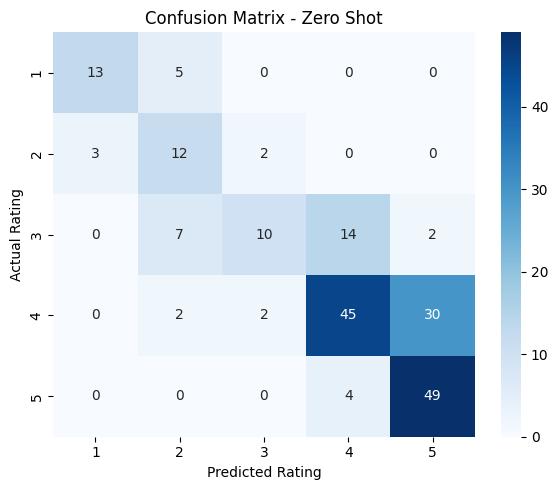


FEW SHOT
Valid predictions: 200/200
Exact match accuracy: 65.00%
Within ±1 star accuracy: 97.00%

              precision    recall  f1-score   support

           1       0.70      0.78      0.74        18
           2       0.50      0.65      0.56        17
           3       0.67      0.30      0.42        33
           4       0.68      0.68      0.68        79
           5       0.65      0.77      0.71        53

    accuracy                           0.65       200
   macro avg       0.64      0.64      0.62       200
weighted avg       0.65      0.65      0.64       200

Saved confusion matrix: figures/confusion_few_shot.png


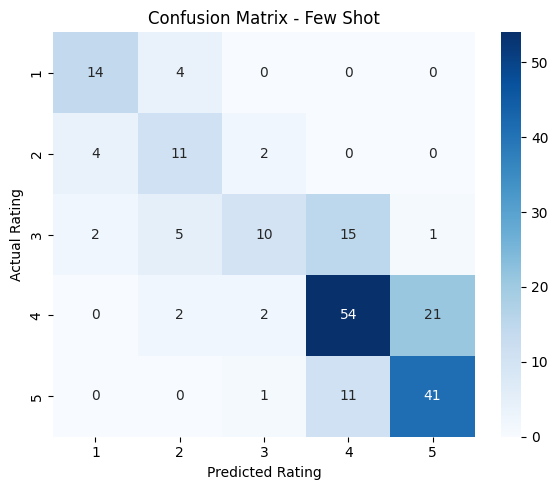


CHAIN OF THOUGHT
Valid predictions: 200/200
Exact match accuracy: 64.50%
Within ±1 star accuracy: 98.00%

              precision    recall  f1-score   support

           1       0.91      0.56      0.69        18
           2       0.48      0.76      0.59        17
           3       0.65      0.39      0.49        33
           4       0.73      0.57      0.64        79
           5       0.60      0.91      0.72        53

    accuracy                           0.65       200
   macro avg       0.67      0.64      0.63       200
weighted avg       0.68      0.65      0.64       200

Saved confusion matrix: figures/confusion_chain_of_thought.png


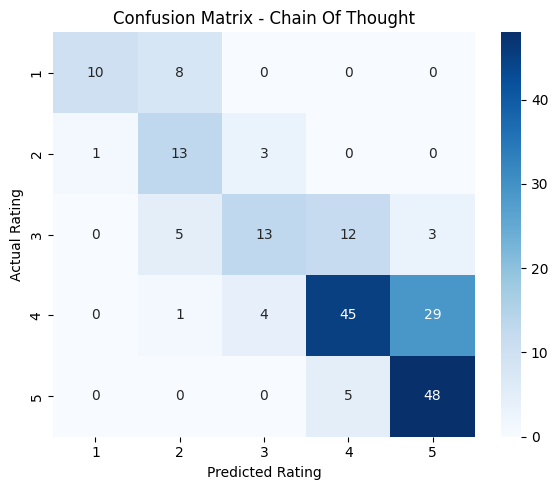

In [ ]:
def evaluate_strategy(actual, predicted, strategy_name):
    
    valid_indices = [i for i, p in enumerate(predicted) if p is not None]
    actual_valid = [actual[i] for i in valid_indices]
    predicted_valid = [predicted[i] for i in valid_indices]

    if len(predicted_valid) == 0:
        print(f"No valid predictions for {strategy_name}")
        return None

    # Metrics
    exact_acc = accuracy_score(actual_valid, predicted_valid)
    within_1 = sum(1 for a, p in zip(actual_valid, predicted_valid) if abs(a - p) <= 1) / len(actual_valid)

    print(f"\n{'='*60}")
    print(f"{strategy_name.upper().replace('_', ' ')}")
    print(f"{'='*60}")
    print(f"Valid predictions: {len(predicted_valid)}/{len(actual)}")
    print(f"Exact match accuracy: {exact_acc:.2%}")
    print(f"Within ±1 star accuracy: {within_1:.2%}")
    print(f"\n{classification_report(actual_valid, predicted_valid, zero_division=0)}")

    # Confusion matrix
    cm = confusion_matrix(actual_valid, predicted_valid, labels=[1, 2, 3, 4, 5])
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[1, 2, 3, 4, 5],
        yticklabels=[1, 2, 3, 4, 5],
    )
    plt.title(f"Confusion Matrix - {strategy_name.replace('_', ' ').title()}")
    plt.ylabel('Actual Rating')
    plt.xlabel('Predicted Rating')
    plt.tight_layout()

    # Save figure
    fig_path = f"figures/confusion_{strategy_name}.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix: {fig_path}")
    plt.show()

    return {'strategy': strategy_name, 'exact_acc': exact_acc, 'within_1': within_1}


# Evaluate all strategies
actual_ratings = test_df['stars'].tolist()
results = []

for strategy_name, data in results_data.items():
    result = evaluate_strategy(actual_ratings, data['predicted_stars'], strategy_name)
    if result:
        results.append(result)

JSON Validity and Reliability/Consistency Metrics

In [ ]:
def compute_json_validity_rate(df_with_outputs):
    """Compute percent of rows where llm_response parses into valid schema."""
    valid = 0
    total = len(df_with_outputs)
    for text in df_with_outputs['llm_response'].fillna(''):
        try:
            _parse_llm_json(str(text))
            valid += 1
        except Exception:
            pass
    return (valid / total) if total else 0.0


def compute_consistency(pred_func, prompts, repeats=3):
    """Run the same prompts multiple times; return pct identical predictions."""
    # predictions[r][i] = predicted_stars
    predictions = []
    for _ in range(repeats):
        run_preds = []
        for p in prompts:
            pred, _, _ = pred_func(p)
            run_preds.append(pred)
        predictions.append(run_preds)

    # If all repeats match the first run for each item -> consistent
    consistent = 0
    for i in range(len(prompts)):
        first = predictions[0][i]
        if all(predictions[r][i] == first for r in range(1, repeats)):
            consistent += 1
    return (consistent / len(prompts)) if prompts else 0.0


print("Added JSON validity + consistency helpers")

Added JSON validity + consistency helpers


## 9. Compare Strategies

In [ ]:
# Build an evaluation table including JSON validity + consistency
eval_rows = []
for strategy, strat_data in results_data.items():
    strat_df = test_df.copy()
    strat_df['predicted_stars'] = strat_data['predicted_stars']
    strat_df['explanation'] = strat_data['explanations']
    strat_df['llm_response'] = strat_data['responses']

    json_validity = compute_json_validity_rate(strat_df)
    valid_mask = strat_df['predicted_stars'].notna()
    exact_acc = accuracy_score(strat_df.loc[valid_mask, 'stars'], strat_df.loc[valid_mask, 'predicted_stars']) if valid_mask.any() else 0.0
    within_1 = (
        (strat_df.loc[valid_mask, 'stars'] - strat_df.loc[valid_mask, 'predicted_stars']).abs().le(1).mean()
        if valid_mask.any()
        else 0.0
    )

    # Consistency: rerun first N prompts of each strategy a few times (cheap but informative)
    N = min(10, len(strat_df))
    prompts = []
    for i in range(N):
        review_text = strat_df.iloc[i]['text']
        if strategy == 'zero_shot':
            prompts.append(zero_shot_prompt(review_text))
        elif strategy == 'few_shot':
            prompts.append(few_shot_prompt(review_text, few_shot_examples))
        else:
            prompts.append(chain_of_thought_prompt(review_text))

    def _pred_func(p):
        if strategy == 'chain_of_thought':
            return get_rating_prediction(p, system_prompt=cot_system_prompt)
        return get_rating_prediction(p)

    consistency = compute_consistency(_pred_func, prompts, repeats=3)
    eval_rows.append({
        'strategy': strategy,
        'n_rows': len(strat_df),
        'valid_prediction_rate': float(valid_mask.mean()),
        'json_validity_rate': float(json_validity),
        'exact_acc': float(exact_acc),
        'within_1_acc': float(within_1),
        'consistency_rate': float(consistency),
    })

comparison_df = pd.DataFrame(eval_rows).sort_values('exact_acc', ascending=False)
print("\n" + "="*60)
print("REQUIREMENTS COMPARISON TABLE")
print("="*60)
display(comparison_df)


REQUIREMENTS COMPARISON TABLE


,strategy,n_rows,valid_prediction_rate,json_validity_rate,exact_acc,within_1_acc,consistency_rate
1,few_shot,200,1.0,1.0,0.650,0.97,1.0
0,zero_shot,200,1.0,1.0,0.645,0.98,1.0
2,chain_of_thought,200,1.0,1.0,0.645,0.98,1.0


## 10. Summary


STRATEGY COMPARISON (ACCURACY)
        strategy  exact_acc  within_1
        few_shot      0.650      0.97
       zero_shot      0.645      0.98
chain_of_thought      0.645      0.98

Saved comparison chart: figures/strategy_comparison.png


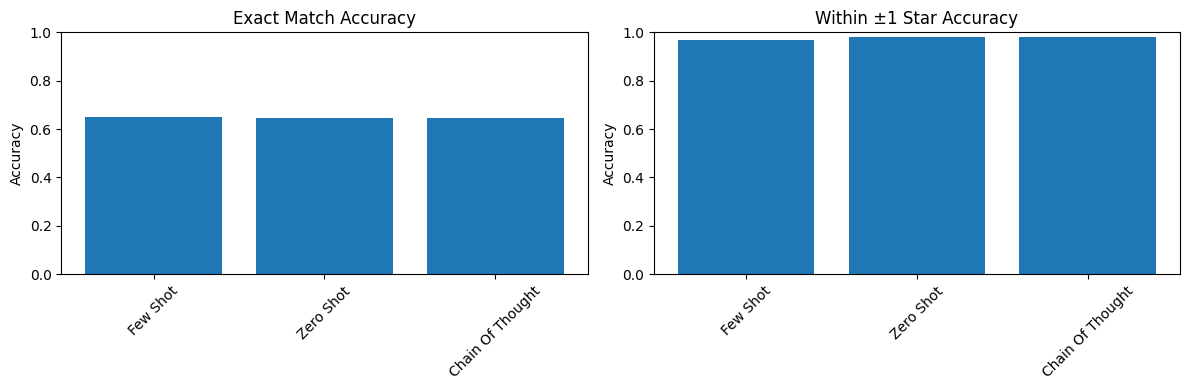


Best strategy (by exact accuracy): Few Shot (65.00%)


In [ ]:
results_df = pd.DataFrame(results).sort_values('exact_acc', ascending=False)

print("\n" + "="*60)
print("STRATEGY COMPARISON (ACCURACY)")
print("="*60)
print(results_df.to_string(index=False))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

strategies = [s.replace('_', ' ').title() for s in results_df['strategy']]

ax[0].bar(strategies, results_df['exact_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Exact Match Accuracy')
ax[0].set_ylim(0, 1)
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(strategies, results_df['within_1'])
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Within ±1 Star Accuracy')
ax[1].set_ylim(0, 1)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('figures/strategy_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved comparison chart: figures/strategy_comparison.png")
plt.show()

if len(results_df) > 0:
    print(f"\nBest strategy (by exact accuracy): {results_df.iloc[0]['strategy'].replace('_', ' ').title()} ({results_df.iloc[0]['exact_acc']:.2%})")